# Time Series Prediction with Lotka Volterra Equation Inspired Deep Learning ($LVPINN$)

AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-11 21:14:44

## Gathering Dependencies

_Importing Required Libraries_

In [16]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [17]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

## Loading Datasets

_TURKEY EARTHQUAKE_

In [18]:
data = pd.read_csv("datasets/eq.csv")
training_set = data.iloc[:, 4]
print(training_set)

0       4.4
1       5.2
2       4.8
3       4.4
4       5.7
       ... 
6569    4.5
6570    4.0
6571    4.4
6572    4.1
6573    4.0
Name: Magnitude, Length: 6574, dtype: float64


## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [19]:
t_diff = 1 # Daily Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

7.9
1       0.8
2      -0.4
3      -0.4
4       1.3
5      -1.4
       ... 
6569    0.4
6570   -0.5
6571    0.4
6572   -0.3
6573   -0.1
Name: Magnitude, Length: 6573, dtype: float64
2      -1.200000e+00
3       8.881784e-16
4       1.700000e+00
5      -2.700000e+00
6       1.100000e+00
            ...     
6569    1.500000e+00
6570   -9.000000e-01
6571    9.000000e-01
6572   -7.000000e-01
6573    2.000000e-01
Name: Magnitude, Length: 6572, dtype: float64


In [20]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0       0.8
1      -0.4
2      -0.4
3       1.3
4      -1.4
       ... 
6568    0.4
6569   -0.5
6570    0.4
6571   -0.3
6572   -0.1
Name: Magnitude, Length: 6573, dtype: float64
0      -1.200000e+00
1       8.881784e-16
2       1.700000e+00
3      -2.700000e+00
4       1.100000e+00
            ...     
6567    1.500000e+00
6568   -9.000000e-01
6569    9.000000e-01
6570   -7.000000e-01
6571    2.000000e-01
Name: Magnitude, Length: 6572, dtype: float64


In [21]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(6573,)
()


## Plot of the External Forcing from Chaotic Differential Equation (_Lotka Volterra Equation_)

_Parameters_: $\alpha=0.1, \beta=0.05, \gamma=1.1, \delta=0.1\\$

<AxesSubplot:>

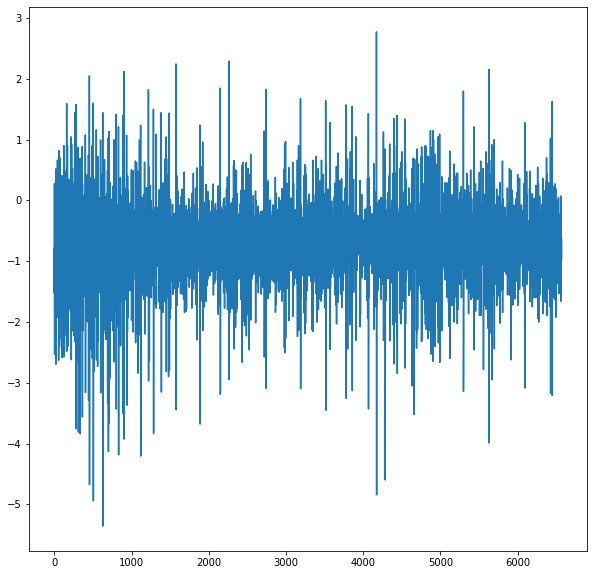

In [22]:
a=0.1
b=0.05
c=1.1
d=0.1
L = df.iloc[:, 2] - a*a*df.iloc[:, 0] + 2*a*b*df.iloc[:, 0]*((a*df.iloc[:, 0]-df.iloc[:, 1])/(b*df.iloc[:, 0])) - b*b*df.iloc[:, 0]*((a*df.iloc[:, 0]-df.iloc[:, 1])/(b*df.iloc[:, 0]))*((a*df.iloc[:, 0]-df.iloc[:, 1])/(b*df.iloc[:, 0])) - b*d*(df.iloc[:,0]**2)*((a*df.iloc[:, 0]-df.iloc[:, 1])/(b*df.iloc[:, 0])) - c*b*df.iloc[:, 0]*((a*df.iloc[:, 0]-df.iloc[:, 1])/(b*df.iloc[:, 0]))
L.plot()

## Preprocessing the Data into Supervised Learning

In [23]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup


data = Supervised(df.values, n_in=10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
           'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
           'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
           'var3(t-2)', 'var2(t-1)', 'var3(t-1)', 'var2(t-3)', 'var3(t-3)'], axis=1, inplace=True)
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:, -3:]
x = data[:, :-3]
print(x.shape)


    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10         4.4        5.2        4.8        4.4        5.7        4.3   
11         5.2        4.8        4.4        5.7        4.3        4.0   
12         4.8        4.4        5.7        4.3        4.0        4.8   
13         4.4        5.7        4.3        4.0        4.8        5.2   
14         5.7        4.3        4.0        4.8        5.2        5.1   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)  var2(t)  var3(t)  
10        4.0        4.8        5.2        5.1      4.7     -0.1     -0.1  
11        4.8        5.2        5.1        4.7      4.6     -0.2      0.5  
12        5.2        5.1        4.7        4.6      4.4      0.3     -0.9  
13        5.1        4.7        4.6        4.4      4.7     -0.6      0.6  
14        4.7        4.6        4.4        4.7      4.1      0.0      0.5  
Index(['var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 'var1(t-4)',

## Train and Test Split

In [24]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(5249, 1, 10) (5249, 3) (1313, 1, 10) (1313, 3)


## Defining the Physical Loss

In [25]:
a = tf.Variable(0.1, name="alpha", trainable=True, dtype=tf.float32)
b = tf.Variable(0.05, name="beta", trainable=True, dtype=tf.float32)
c = tf.Variable(1.1, name="gamma", trainable=True, dtype=tf.float32)
d = tf.Variable(0.1, name="delta", trainable=True, dtype=tf.float32)


def phys(y_pred, y_true):
    return mean_absolute_error((y_true[:, 2] - a*a*y_true[:, 0] + 2*a*b*y_true[:, 0]*((a*y_true[:, 0]-y_true[:, 1])/(b*y_true[:, 0])) - b*b*y_true[:, 0]*((a*y_true[:, 0]-y_true[:, 1])/(b*y_true[:, 0]))*((a*y_true[:, 0]-y_true[:, 1])/(b*y_true[:, 0])) - b*d*(y_true[:,0]**2)*((a*y_true[:, 0]-y_true[:, 1])/(b*y_true[:, 0])) - c*b*y_true[:, 0]*((a*y_true[:, 0]-y_true[:, 1])/(b*y_true[:, 0]))), (y_pred[:, 2] - a*a*y_pred[:, 0] + 2*a*b*y_pred[:, 0]*((a*y_pred[:, 0]-y_pred[:, 1])/(b*y_pred[:, 0])) - b*b*y_pred[:, 0]*((a*y_pred[:, 0]-y_pred[:, 1])/(b*y_pred[:, 0]))*((a*y_pred[:, 0]-y_pred[:, 1])/(b*y_pred[:, 0])) - b*d*(y_pred[:,0]**2)*((a*y_pred[:, 0]-y_pred[:, 1])/(b*y_pred[:, 0])) - c*b*y_pred[:, 0]*((a*y_pred[:, 0]-y_pred[:, 1])/(b*y_pred[:, 0]))))

def phys2(y_pred, y_real):
    pred = y_pred[2:]-2*y_pred[1:-1]-y_pred[:-2] - a*a*y_pred[:-2] + 2*a*b*y_pred[:-2]*((a*y_pred[:-2]-(y_pred[1:-1]-y_pred[:-2]))/(b*y_pred[:-2])) - b*b*y_pred[:-2]*((a*y_pred[:-2]-(y_pred[1:-1]-y_pred[:-2]))/(b*y_pred[:-2]))*((a*y_pred[:-2]-(y_pred[1:-1]-y_pred[:-2]))/(b*y_pred[:-2])) - b*d*(y_pred[:-2]**2)*((a*y_pred[:-2]-(y_pred[1:-1]-y_pred[:-2]))/(b*y_pred[:-2])) - c*b*y_pred[:-2]*((a*y_pred[:-2]-(y_pred[1:-1]-y_pred[:-2]))/(b*y_pred[:-2]))
    real = y_real[2:]-2*y_real[1:-1]-y_real[:-2] - a*a*y_real[:-2] + 2*a*b*y_real[:-2]*((a*y_real[:-2]-(y_real[1:-1]-y_real[:-2]))/(b*y_real[:-2])) - b*b*y_real[:-2]*((a*y_real[:-2]-(y_real[1:-1]-y_real[:-2]))/(b*y_real[:-2]))*((a*y_real[:-2]-(y_real[1:-1]-y_real[:-2]))/(b*y_real[:-2])) - b*d*(y_real[:-2]**2)*((a*y_real[:-2]-(y_real[1:-1]-y_real[:-2]))/(b*y_real[:-2])) - c*b*y_real[:-2]*((a*y_real[:-2]-(y_real[1:-1]-y_real[:-2]))/(b*y_real[:-2]))
    return(mean_absolute_error(pred, real))

## Model ($LVPINN$)

In [26]:
a = tf.Variable(0.1, name="alpha", trainable=True, dtype=tf.float32)
b = tf.Variable(0.05, name="beta", trainable=True, dtype=tf.float32)
c = tf.Variable(1.1, name="gamma", trainable=True, dtype=tf.float32)
d = tf.Variable(0.1, name="delta", trainable=True, dtype=tf.float32)

def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    squared_difference3 = tf.square(y_pred[:, 2] - a*a*y_pred[:, 0] + 2*a*b*y_pred[:, 0]*((a*y_pred[:, 0]-y_pred[:, 1])/(b*y_pred[:, 0])) - b*b*y_pred[:, 0]*((a*y_pred[:, 0]-y_pred[:, 1])/(b*y_pred[:, 0]))*((a*y_pred[:, 0]-y_pred[:, 1])/(b*y_pred[:, 0])) - b*d*(y_pred[:,0]**2)*((a*y_pred[:, 0]-y_pred[:, 1])/(b*y_pred[:, 0])) - c*b*y_pred[:, 0]*((a*y_pred[:, 0]-y_pred[:, 1])/(b*y_pred[:, 0])))
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(3))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64,
                    validation_data=(testX, testY), verbose=2, shuffle=False)

Epoch 1/500
83/83 - 24s - loss: 0.0171 - val_loss: 0.0085 - 24s/epoch - 284ms/step
Epoch 2/500
83/83 - 1s - loss: 0.0133 - val_loss: 0.0086 - 766ms/epoch - 9ms/step
Epoch 3/500
83/83 - 1s - loss: 0.0130 - val_loss: 0.0086 - 792ms/epoch - 10ms/step
Epoch 4/500
83/83 - 1s - loss: 0.0129 - val_loss: 0.0086 - 829ms/epoch - 10ms/step
Epoch 5/500
83/83 - 1s - loss: 0.0128 - val_loss: 0.0086 - 734ms/epoch - 9ms/step
Epoch 6/500
83/83 - 1s - loss: 0.0128 - val_loss: 0.0086 - 861ms/epoch - 10ms/step
Epoch 7/500
83/83 - 1s - loss: 0.0128 - val_loss: 0.0085 - 792ms/epoch - 10ms/step
Epoch 8/500
83/83 - 1s - loss: 0.0129 - val_loss: 0.0085 - 766ms/epoch - 9ms/step
Epoch 9/500
83/83 - 1s - loss: 0.0129 - val_loss: 0.0085 - 777ms/epoch - 9ms/step
Epoch 10/500
83/83 - 1s - loss: 0.0129 - val_loss: 0.0085 - 922ms/epoch - 11ms/step
Epoch 11/500
83/83 - 1s - loss: 0.0129 - val_loss: 0.0085 - 678ms/epoch - 8ms/step
Epoch 12/500
83/83 - 1s - loss: 0.0129 - val_loss: 0.0085 - 628ms/epoch - 8ms/step
Epoch 1

## Metrics ($LVPINN$)

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
phy = phys2(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

42/42 [==============================] - 2s 4ms/step
(1313, 3)
(1313, 10)
Test RMSE: 0.360
Test MAE: 0.256


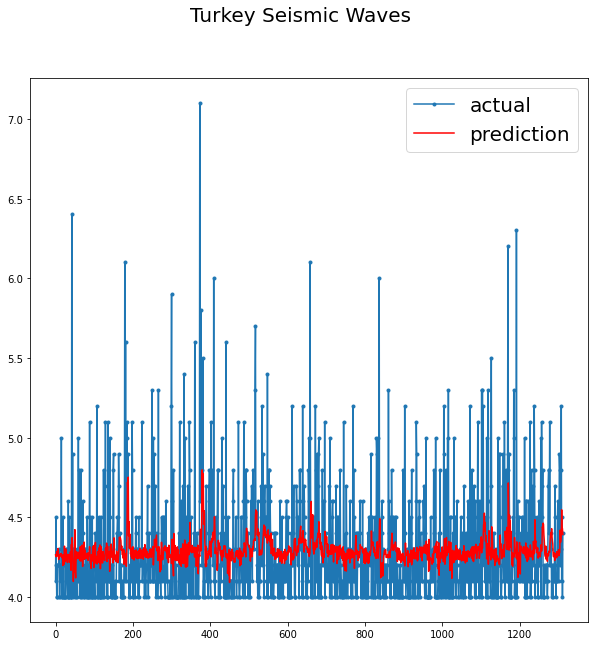

In [28]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('Turkey Seismic Waves', fontsize=20)
plt.legend(fontsize=20)
plt.show()